In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt

from sat_metropolis import smt, mcmc, sat, utils

In [2]:
# Assumption, all bit-vectors are of the same size
## NOTE: It looks like we need to always have one extra bit? For the sign?
num_bits = 4
num_vars = 3
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2]])) # important
g.add(ULE(0,x[0]))
g.add(ULE(x[0],3))
g.add(ULE(0,x[1]))
g.add(ULE(x[1],3))
g.add(ULE(0,x[2]))
g.add(ULE(x[2],6))
g.add(x[0] + x[1]  == x[2])

In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 422a9dbaba3f749c2df811d9dfab7ffd4627bac5
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -mtune=native -Wall -Wextra -Wunused -Wsign-compare -fno-omit-frame-pointer -Wtype-limits -Wuninitialized -Wno-deprecated -Wstrict-aliasing -Wpointer-arith -Wpointer-arith -Wformat-nonliteral -Winit-self -Wparentheses -Wunreachable-code -ggdb3 -Wno-class-memaccess -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = OFF | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING =  | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = ON | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 13.2.0
c executed with command line: cmsgen --samples 30000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing sam

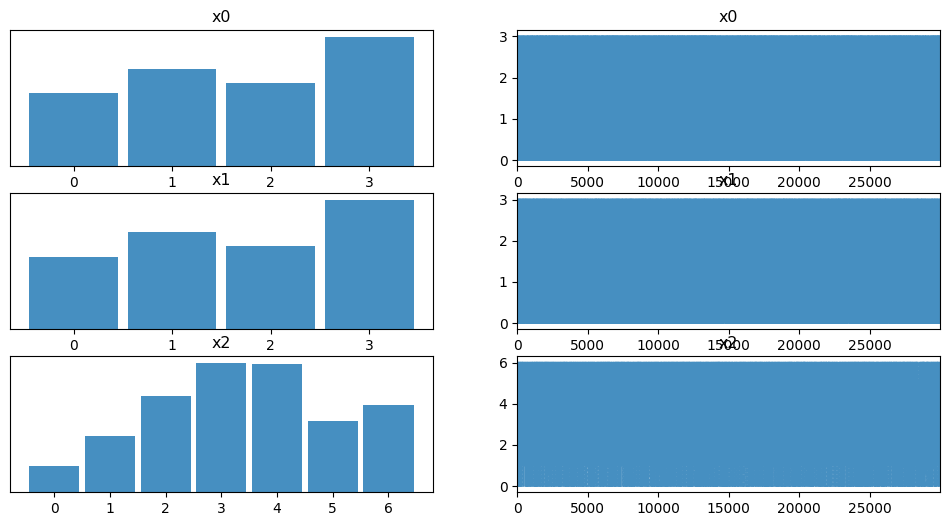

In [4]:
# Trace plot
az.plot_trace(trace);
plt.savefig('cmsgen_triangle_trace_plot.png',dpi=150);

In [5]:
# Diagnosis
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.705,1.125,0.0,3.0,0.003,0.001,119979.0,119994.0,1.0
x1,1.707,1.124,0.0,3.0,0.003,0.001,118689.0,117450.0,1.0
x2,3.412,1.670,1.0,6.0,0.005,0.003,120501.0,120000.0,1.0


In [6]:
utils.save_trace(trace, f'triangle_SAT_cmsgen_{num_vars}_{num_bits}.nc')

## Non-uniform prior

In [7]:
def prior(s: dict[str, int]):
    x0 = s['x0']
    x1 = s['x1']
    p_x0 = 1/3 if x0 < 2 else 1/6
    p_x1 = 1/4

    return p_x0 * p_x1

def likelihood(s: dict[str, int]):
    return 1

In [8]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4,
                                           f= lambda s: prior(s)*likelihood(s))

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 422a9dbaba3f749c2df811d9dfab7ffd4627bac5
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -mtune=native -Wall -Wextra -Wunused -Wsign-compare -fno-omit-frame-pointer -Wtype-limits -Wuninitialized -Wno-deprecated -Wstrict-aliasing -Wpointer-arith -Wpointer-arith -Wformat-nonliteral -Winit-self -Wparentheses -Wunreachable-code -ggdb3 -Wno-class-memaccess -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = OFF | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING =  | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = ON | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 13.2.0
c executed with command line: cmsgen --samples 30000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing sam

### Posterior analysis

We observe the in the traceplot below the effect of the prior on $x_0$. Now it is distributed as according to the categorical distribution above. As opposed to the uniform prior we used in the previous analysis.

The distribution of $x_2$ is also affected by the new prior on $x_0$.

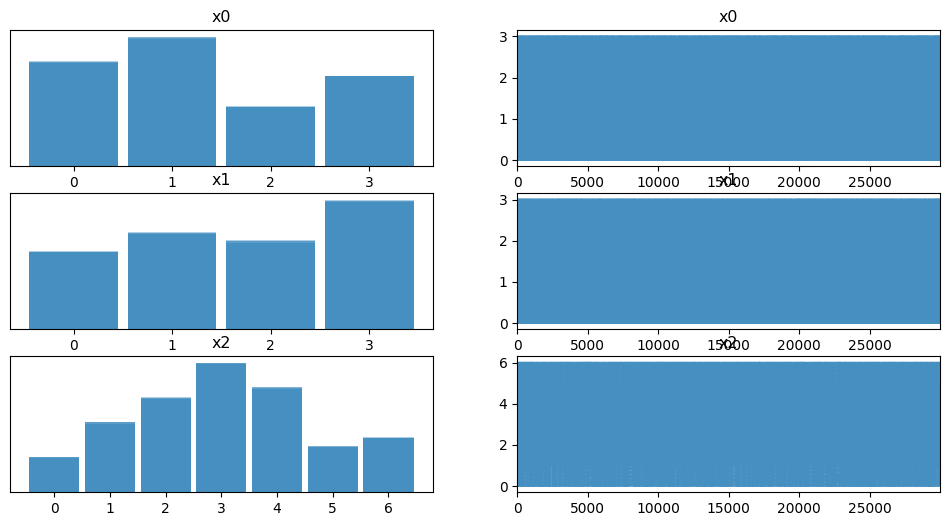

In [9]:
az.plot_trace(trace);
plt.savefig('cmsgen_trace_plot_non_uniform.png',dpi=150);

In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.354,1.117,0.0,3.0,0.004,0.002,67702.0,64904.0,1.0
x1,1.686,1.127,0.0,3.0,0.004,0.002,80412.0,79281.0,1.0
x2,3.040,1.658,0.0,6.0,0.006,0.003,72876.0,65125.0,1.0


In [11]:
utils.save_trace(trace, f'triangle_prior_SAT_cmsgen_{num_vars}_{num_bits}.nc')